In [1]:
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors

import pandas
print(pandas.__version__)

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 245    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [2*fig_width, 2*fig_height]
rcParams.update({'figure.figsize': fig_size})

1.1.5


In [2]:
def extract_forecasts(data, forecast_period):
    
    dates = []
    dates_pivot = []
    data_quantile_0025_cont = []
    data_quantile_0975_cont = []
    data_point_cont = []
    
    for file in sorted(os.listdir(ensemble_forecast_directory))[7:]:    

        if file[-4:] == '.csv':
            
            data = pd.read_csv(ensemble_forecast_directory+file)
            
            data = data[data['location'] == 'US']
                
            data_quantile = data[data['type'] == 'quantile']
                        
            data_quantile_0025 = data[data['quantile'] == 0.025]    
            data_quantile_0975 = data[data['quantile'] == 0.975]     
            
            data_point = data[data['type'] == 'point']
            
            dates_pivot.append(data_point[data_point['target'] == forecast_period]['forecast_date'].to_numpy()[0])
            
            dates.append(data_quantile_0025[data_quantile_0025['target'] == forecast_period]['target_end_date'].to_numpy()[0])
            data_quantile_0025_cont.append(float(data_quantile_0025[data_quantile_0025['target'] == forecast_period]['value']))
            data_quantile_0975_cont.append(float(data_quantile_0975[data_quantile_0975['target'] == forecast_period]['value']))
            data_point_cont.append(float(data_point[data_point['target'] == forecast_period]['value']))
    
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
    dates_pivot = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates_pivot]
    
    return np.asarray(dates), np.asarray(dates_pivot), np.asarray(data_quantile_0025_cont), np.asarray(data_quantile_0975_cont), np.asarray(data_point_cont)

In [3]:
covid_data = pd.read_csv('../../data/time_series_covid19_deaths_US.csv')

print(covid_data.head())
colnames = covid_data.columns.tolist()

        UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
4  84001009   US  USA    840  1009.0   Blount        Alabama             US   

         Lat      Long_  ... 5/21/21  5/22/21  5/23/21  5/24/21  5/25/21  \
0  32.539527 -86.644082  ...     109      110      110      110      110   
1  30.727750 -87.722071  ...     310      310      310      310      310   
2  31.868263 -85.387129  ...      58       58       58       58       58   
3  32.996421 -87.125115  ...      64       64       64       64       64   
4  33.982109 -86.567906  ...     139      139      139      139      139   

   5/26/21  5/27/21  5/28/21  5/29/21  5/30/21  
0      110      110

2020-01-22 00:00:00 2021-05-30 00:00:00


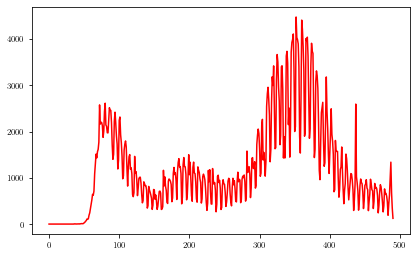

In [4]:
start = datetime.datetime.strptime(colnames[12], "%m/%d/%y")
end = datetime.datetime.strptime(colnames[-1], "%m/%d/%y")

print(start, end)

dates_covid_data = np.asarray([start + datetime.timedelta(days=x) for x in range(0, (end-start).days)])
dates_covid_data = dates_covid_data[3:][::7]

deaths_covid_data = [covid_data.iloc[:,i].sum() for i in range(12,len(colnames))]
deaths_covid_data_dates = [colnames[i] for i in range(12,len(colnames))]

original_cum_signal = deaths_covid_data[3:]
deaths_covid_data = np.diff(deaths_covid_data[3:])
plt.plot(deaths_covid_data,'r')

original_signal = deaths_covid_data
original_signal_dates = deaths_covid_data_dates[4:]

In [5]:
ensemble_forecast_directory = '../../data/COVIDhub-ensemble/'

dates_1wk, dates_forecast_1wk, data_quantile_0025_1wk, data_quantile_0975_1wk, data_point_1wk = \
extract_forecasts(ensemble_forecast_directory, '1 wk ahead inc death')

dates_2wk, dates_forecast_1wk, data_quantile_0025_2wk, data_quantile_0975_2wk, data_point_2wk = \
extract_forecasts(ensemble_forecast_directory, '2 wk ahead inc death')

dates_3wk, dates_forecast_1wk, data_quantile_0025_3wk, data_quantile_0975_3wk, data_point_3wk = \
extract_forecasts(ensemble_forecast_directory, '3 wk ahead inc death')

dates_4wk, dates_forecast_1wk, data_quantile_0025_4wk, data_quantile_0975_4wk, data_point_4wk = \
extract_forecasts(ensemble_forecast_directory, '4 wk ahead inc death')

In [6]:
print(dates_1wk[0], dates_forecast_1wk[0])

2020-06-13 00:00:00 2020-06-08 00:00:00


In [7]:
def euler_lagrange(signal_cum_df__, weeks__ = 1, diff_length__ = 7):
    assert signal_cum_df__[-1]>signal_cum_df__[-2] # monotone increasing check
    
    print("euler-lagrange method input:", signal_cum_df__.tail())
    
    # get discrete derivative [diff_length__] of signal_cum_df_ -- cumulative numbers -- less noisy)
    derivative_week_discrete = signal_cum_df__[-1] - signal_cum_df__[-diff_length__]  
    print("euler-lagrange derivative:", derivative_week_discrete)
    
    # total variation optimization to denoise 2nd derivative 
    xinv = extract_min_total_variation_optimization(signal_cum_df__.to_numpy())
            
    # 2nd derivative after total variation optimization 
    derivative__2nd_daily = (xinv[-1] - xinv[-2])
    print("euler-lagrange 2nd derivative:", derivative__2nd_daily)
            
    derivative_corr =  weeks__*7*derivative__2nd_daily
    print("number of weeks to future and correction", weeks__, derivative_corr)
    euler_lagrange_pred = derivative_week_discrete + derivative_corr
    
    return euler_lagrange_pred
    
import pylops
def extract_min_total_variation_optimization(original_signal__):
    y = np.diff(original_signal__)
    nx = len(y)
    Iop = pylops.Identity(nx)
    
    # Model: y = Iop*(x + n), n - noise, 
    # xinv = argmin ||y-Ix||_2 + lambda*||\grad[x]||_2
    
    D2op = pylops.SecondDerivative(nx, edge=True)
    lamda = 100e2
    xinv = pylops.optimization.leastsquares.RegularizedInversion(Iop, [D2op], y,
                                                          epsRs=[np.sqrt(lamda/2)],
                                                          **dict(iter_lim=30))
    
    return xinv

In [8]:
def error_comparison_all_raw(covid_data_raw__, cdc_ensemble_forecast__, cdc_dates__, weeks__):
    # total variation on derivative + reconstruction minimization ~ Euler-Lagrange 
    div = 1
    error_euler = []
    error_ensemble = []
    error_date = []
    euler_pred_list = []
    cdc_pred_list = []
    pivot_date = []
    for i in range(len(cdc_dates__)):
        date_tmp = cdc_dates__[i]
        print("prediction date", date_tmp.strftime("%-m/%-d/%y"))
        ind = np.where(covid_data_raw__.columns == date_tmp.strftime("%-m/%-d/%y"))
        if len(ind[0]):
            error_date.append(date_tmp)
            ind = ind[0][0]
            
            print("ind element on covid data",ind,  covid_data.iloc[:,ind].sum())
            
            current_week_slice = covid_data.iloc[:,ind-7+1:ind+1].sum()
            print("current week (prediction week)", current_week_slice)
            
            current_week_death_diff = current_week_slice[-1]-current_week_slice[0]
            print("current week dead diff", current_week_death_diff)
 
            all_history_slice = covid_data.iloc[:,12:ind-7*weeks__+1+1].sum()
            print("historical slice",all_history_slice.tail(14))
            print("last date history", all_history_slice.index[-1])
            pivot_date.append( datetime.datetime.strptime(all_history_slice.index[-1], "%m/%d/%y") )
        
            euler_pred = euler_lagrange(all_history_slice, weeks__)
            euler_pred_list.append(euler_pred)
            print("euler pred with dedicated function", euler_pred)
            
            error_euler.append(abs(euler_pred-current_week_death_diff))
            error_ensemble.append(abs(cdc_ensemble_forecast__[i]-current_week_death_diff))
            cdc_pred_list.append(cdc_ensemble_forecast__[i])
            
            print(f"cdc estimate {cdc_ensemble_forecast__[i]} for {cdc_dates__[i]} or {date_tmp}")
      
    error_euler = np.transpose(np.asarray(error_euler)/div)
    error_ensemble =  np.transpose(np.asarray(error_ensemble)/div )
    error_euler_cum =  np.transpose(np.cumsum(error_euler))
    error_ensemble_cum =  np.transpose(np.cumsum(error_ensemble))
    error_date =  np.transpose(np.asarray(error_date))
    euler_pred_list = np.transpose(np.asarray(euler_pred_list))
    cdc_pred_list = np.transpose(np.asarray(cdc_pred_list))
    
    print(error_euler.shape)
    
    data = [error_euler, error_ensemble, error_euler_cum, error_ensemble_cum, error_date,pivot_date,\
            euler_pred_list, cdc_pred_list]
    df = pd.DataFrame(data).T
    
    df.columns = ["error_euler","error_cdc_ensemble","cum_error_euler",\
                                       "cum_error_cdc_ensemble","target_prediction_date", "prediction_made_date",\
                 "euler_prediction_value", "cdc_prediction_]
    
    return df
    #return error_euler, error_ensemble, error_euler_cum, error_ensemble_cum, error_date

In [9]:
week_forecast = 1
df = error_comparison_all_raw(covid_data, data_point_1wk, dates_1wk, week_forecast)

prediction date 6/13/20
ind element on covid data 155 118302
current week (prediction week) 6/7/20     113612
6/8/20     114119
6/9/20     115032
6/10/20    115908
6/11/20    116738
6/12/20    117567
6/13/20    118302
dtype: int64
current week dead diff 4690
historical slice 5/25/20    101897
5/26/20    102574
5/27/20    104037
5/28/20    105138
5/29/20    106271
5/30/20    107225
5/31/20    107840
6/1/20     108616
6/2/20     109597
6/3/20     110607
6/4/20     111620
6/5/20     112511
6/6/20     113153
6/7/20     113612
dtype: int64
last date history 6/7/20
euler-lagrange method input: 6/3/20    110607
6/4/20    111620
6/5/20    112511
6/6/20    113153
6/7/20    113612
dtype: int64
euler-lagrange derivative: 4996
euler-lagrange 2nd derivative: -40.04606770174689
number of weeks to future and correction 1 -280.32247391222825
euler pred with dedicated function 4715.677526087772
cdc estimate 5773.725831488972 for 2020-06-13 00:00:00 or 2020-06-13 00:00:00
prediction date 6/20/20
ind ele

historical slice 9/28/20     205425
9/29/20     206259
9/30/20     207217
10/1/20     208090
10/2/20     208950
10/3/20     209634
10/4/20     210015
10/5/20     210495
10/6/20     211181
10/7/20     212108
10/8/20     213097
10/9/20     214065
10/10/20    214723
10/11/20    215194
dtype: int64
last date history 10/11/20
euler-lagrange method input: 10/7/20     212108
10/8/20     213097
10/9/20     214065
10/10/20    214723
10/11/20    215194
dtype: int64
euler-lagrange derivative: 4699
euler-lagrange 2nd derivative: 0.12529246027600038
number of weeks to future and correction 1 0.8770472219320027
euler pred with dedicated function 4699.877047221932
cdc estimate 5089.0 for 2020-10-17 00:00:00 or 2020-10-17 00:00:00
prediction date 10/24/20
ind element on covid data 288 225771
current week (prediction week) 10/18/20    220415
10/19/20    220894
10/20/20    221818
10/21/20    222939
10/22/20    223853
10/23/20    224820
10/24/20    225771
dtype: int64
current week dead diff 5356
historic

historical slice 2/1/21     451515
2/2/21     454945
2/3/21     458852
2/4/21     462589
2/5/21     466277
2/6/21     468918
2/7/21     470355
2/8/21     471972
2/9/21     475047
2/10/21    478357
2/11/21    481565
2/12/21    484494
2/13/21    486692
2/14/21    487853
dtype: int64
last date history 2/14/21
euler-lagrange method input: 2/10/21    478357
2/11/21    481565
2/12/21    484494
2/13/21    486692
2/14/21    487853
dtype: int64
euler-lagrange derivative: 15881
euler-lagrange 2nd derivative: -111.58233411277843
number of weeks to future and correction 1 -781.076338789449
euler pred with dedicated function 15099.92366121055
cdc estimate 17715.0 for 2021-02-20 00:00:00 or 2021-02-20 00:00:00
prediction date 2/27/21
ind element on covid data 414 513990
current week (prediction week) 2/21/21    501185
2/22/21    502508
2/23/21    504782
2/24/21    507961
2/25/21    510407
2/26/21    512475
2/27/21    513990
dtype: int64
current week dead diff 12805
historical slice 2/8/21     471972

In [285]:
print(df.head())
df.to_csv(f'../../results/error_euler_langrange_cdc_week_{week_forecast}.csv')

#datetime.datetime.strptime("6/14/20", "%m/%d/%y")

  error_euler error_cdc_ensemble cum_error_euler cum_error_cdc_ensemble  \
0     1279.59            1083.73         1279.59                1083.73   
1     609.355            1064.47         1888.94                2148.19   
2     890.155            351.871          2779.1                2500.06   
3     126.168            1095.09         2905.26                3595.15   
4     1550.55            1123.87         4455.81                4719.02   

  target_prediction_date prediction_made_date  
0             2020-06-13           2020-05-31  
1             2020-06-20           2020-06-07  
2             2020-06-27           2020-06-14  
3             2020-07-04           2020-06-21  
4             2020-07-11           2020-06-28  


/Users/anino/anaconda3/envs/network_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/anino/anaconda3/envs/network_env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/anino/anaconda3/envs/network_env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


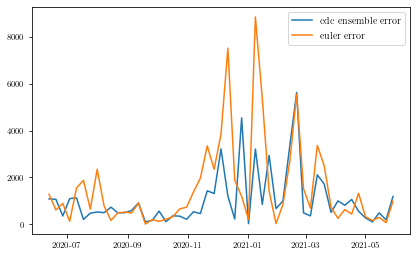

In [286]:
plt.plot(df["target_prediction_date"], df["error_cdc_ensemble"])
plt.plot(df["target_prediction_date"], df["error_euler"])

plt.legend(['cdc ensemble error','euler error'])

plt.savefig(f'../../results/prediction_error_euler_langrange_week_{week_forecast}.png', dpi = 600)

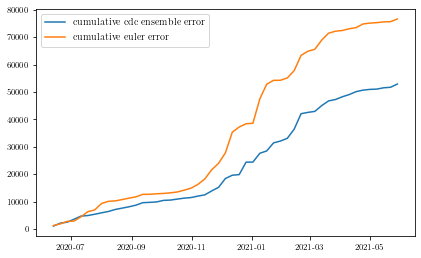

In [287]:
plt.plot(df["target_prediction_date"], df["cum_error_cdc_ensemble"])
plt.plot(df["target_prediction_date"], df["cum_error_euler"])

plt.legend(['cumulative cdc ensemble error','cumulative euler error'])

plt.savefig(f'../../results/cumulative_prediction_error_euler_langrange_week_{week_forecast}.png', dpi = 600)

In [288]:
print("cum cdc error: ", df["cum_error_cdc_ensemble"].iloc[-1])
print("cum euler error: ",  df["cum_error_euler"].iloc[-1])

cum cdc error:  52884.9982674756
cum euler error:  76603.4322231171
